# Predict Bankrupcy

*The data is used from challenge in http://www.scriptedin.com*

### Lets explore the data first

In [3]:
import pandas as pd

data=pd.read_csv("../bankruptcytrainpost.csv")

#check first few values
print(data.head())

#check for missing values and data types
print(data.info())

#check summary statistics in each numerical column
print(data.describe())

#how the target values are distributed?
print(data["FAIL"].value_counts())

   SALES     ROCE    FFTL    GEAR    CLTA    CACL    QACL    WCTA  LAG  AGE  \
0   7646  31.2239  0.6312  0.5205  0.4829  1.6397  1.4935  0.3089  286   25   
1  36067  10.9613  0.3540  0.3786  0.3786  1.5852  1.1626  0.2216  301   33   
2  16737  17.9949  0.4388  0.5236  0.4347  1.1748  0.9795  0.0760   55   26   
3  48162   6.1787  0.1181  0.9996  0.7437  1.3007  0.9070  0.2236  303   34   
4   6953   0.0648  0.1447  0.9520  0.4976  1.0410  0.5355  0.0204  362   14   

   CHAUD  BIG6  FAIL  
0      0     0     0  
1      0     1     0  
2      0     1     0  
3      0     0     1  
4      1     1     1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 13 columns):
SALES    44 non-null int64
ROCE     44 non-null float64
FFTL     44 non-null float64
GEAR     44 non-null float64
CLTA     44 non-null float64
CACL     44 non-null float64
QACL     44 non-null float64
WCTA     44 non-null float64
LAG      44 non-null int64
AGE      44 non-null int64


All the features are numeric more importantly no missing values!!. Looks like we may need to scale the data as some features going to dominate the model if we directly use the raw data. Let's start with simplest form of logistic regression model.

### Simple Logistic Regression Model

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#drop the target to have all features on X
X=data.drop('FAIL',axis=1).values
y=data['FAIL'].values

#split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

logreg = LogisticRegression()

#fit model on training data
logreg.fit(X_train, y_train)

#model accuracy
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.71


Let's see whether we can improve the accuracy of the by scaling the data.

### Standard Scaler on the Data

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# setup the pipeline steps
steps = [('scaler', StandardScaler()),
        ('lr', LogisticRegression())]
        
# create the pipeline
pipeline = Pipeline(steps)

#fit the pipeline to the training set
lr_scaled = pipeline.fit(X_train,y_train)

print('Accuracy with Scaling: {:.2f}'.format(lr_scaled.score(X_test,y_test)))

Accuracy with Scaling: 0.79


Look like it improved the accuracy. Logistic Regression is using Hyperparameter "C". Can we tune that inorder to get a better model.

### Hyperparameter Tuning

In [6]:
from sklearn.model_selection import GridSearchCV

parameters = {'lr__C': [0.001,0.01,0.1,1,10,100]}

#tune the parameter from GridSearch
lr_gs = GridSearchCV(pipeline,param_grid= parameters)

lr_gs.fit(X_train,y_train)

print('Accuracy with Hyperparameter tuning: {:.2f}'.format(lr_gs.score(X_test,y_test)))

Accuracy with Hyperparameter tuning: 0.86


Scaling plus Hyperparameter tuning gives the best model so far. Let's check precision and recall.

### Confusion Matrix and Classification Report

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#predict y values on X test
y_pred=lr_gs.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

[[8 1]
 [1 4]]
             precision    recall  f1-score   support

          0       0.89      0.89      0.89         9
          1       0.80      0.80      0.80         5

avg / total       0.86      0.86      0.86        14



Let's check the ROC curve. Sample size is small and there are not much continous features available. Therefore curve is not going to be a smooth one.


### ROC Curve


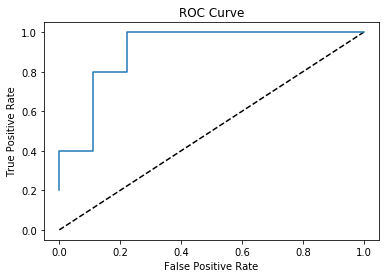

In [11]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

#need probabilities rather than 1 or 0
y_pred_prob=lr_gs.predict_proba(X_test)[:,1]

fpr,tpr,threshold= roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()